In [1]:
## By:             Will Cassidy
## Email:          william.cassidy@chicagobooth.edu
## Date:           6/18/2017
## Description:    Visualizations for civil war project

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
import shapely
from descartes import PolygonPatch
from matplotlib.collections import PatchCollection
from matplotlib.colors import rgb2hex
from matplotlib.patches import Polygon
from math import log
import geopy

%matplotlib inline

root = r'C:/Users/wcassidy/Dropbox/CivilWar'
shape_files = root + '/data/shape_files/'
voting_path = root + '/data/votes/intermediate/'
figures = root + '/output/figures/'
casualty_dir = root + '/data/casualties/intermediate/'

In [2]:
slave_states = ['Alabama', 'Arkansas', 'Florida', 'Georgia', 'Louisiana',
                'Mississippi', 'North Carolina', 'South Carolina', 'Tennessee',
                'Texas', 'Virginia', 'Missouri', 'Kentucky', 'Maryland',
                'West Virginia', 'Delaware']

confederacy = ['Alabama', 'Arkansas', 'Florida', 'Georgia', 'Louisiana',
               'Mississippi', 'North Carolina', 'South Carolina', 'Tennessee',
               'Texas', 'Virginia']

In [3]:
## Voting Data 
voting_data = pd.read_csv(voting_path + 'voting.csv')

voting_data.Democratic_1860 = voting_data.Democratic_1860.fillna(value=0)
voting_data.Democratic_1876 = voting_data.Democratic_1876.fillna(value=0)
    
voting_data['southern_dem_share'] = voting_data['Other1_1860'] / voting_data['Total_1860']
voting_data['union_share'] = voting_data['Other2_1860'] / voting_data['Total_1860']
voting_data['northern_dem_share'] = voting_data['Democratic_1860'] / voting_data['Total_1860']

voting_data['margin_1860'] = (voting_data['southern_dem_share'] 
                              - voting_data['union_share'] 
                              - voting_data['northern_dem_share'])

voting_data['dem_share_1876'] = voting_data['Democratic_1876'] / voting_data['Total_1876']
voting_data['rep_share_1876'] = voting_data['Republican_1876'] / voting_data['Total_1876']

voting_data['margin_1876'] = voting_data['dem_share_1876'] - voting_data['rep_share_1876']

voting_data.state = voting_data.state.str.lower()
voting_data.county = voting_data.county.str.lower()

## Heatmap based on democratic vote share
colors = {}
county_names = []
cmap = plt.cm.Blues
vmin = 0; vmax = 0

# Better to write a discretize function
vote_dict_1860 = {tuple(x[:2]): cmap(x[2]) for x in 
                  voting_data.loc[pd.notnull(voting_data.southern_dem_share), ['state', 'county', 'southern_dem_share']].values}
vote_dict_1870 = {tuple(x[:2]): cmap(x[2]) for x in 
                  voting_data.loc[pd.notnull(voting_data.margin_1876), ['state', 'county', 'margin_1876']].values}

## Need to think more about this. Also relevant are other parties, etc.
## Unclear that democratic vote is what we want

vote_dict_1860 = {(('virginia', k[1]) if (k[0] == 'west virginia') else k): v for k, v in vote_dict_1860.items()}
vote_dict_1860 = {(('virginia', 'monroe (w.va.)') if (k == ('virginia', 'monroe')) else k): v 
                      for k, v in vote_dict_1860.items()}
vote_dict_1870 = {(('alabama', 'baker') if (k == ('alabama', 'chilton')) else k): v for k, v in vote_dict_1870.items()}

voting_data, votes = None, None

In [4]:
## Battle Casualty Data
casualties = pd.read_csv(casualty_dir + 'casualties.csv')
casualties = casualties[pd.notnull(casualties.latitude)]

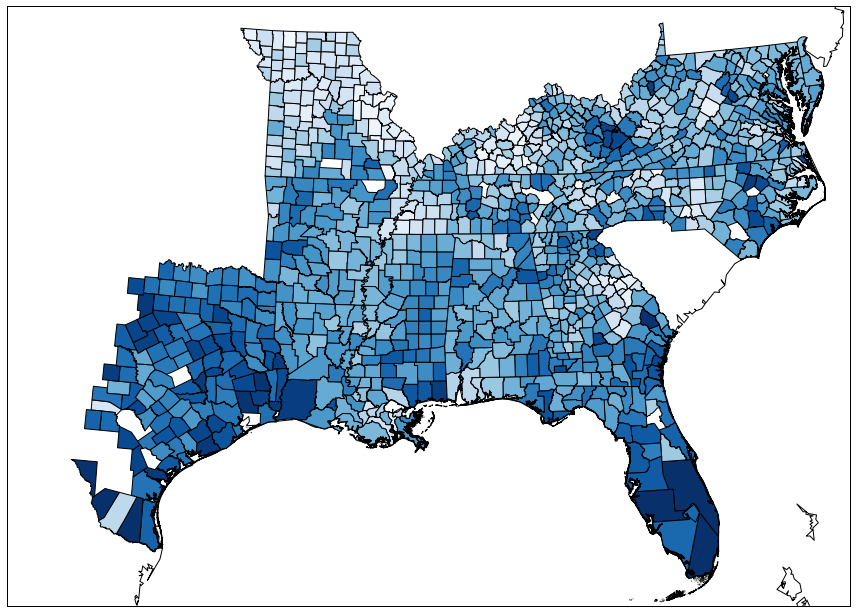

In [14]:
## (1) Graph for election of 1860
water = 'lightskyblue'
earth = 'cornsilk'
 
fig, ax1 = plt.subplots(figsize=(12, 10))
mm = Basemap(
    width=2600000, height=1850000,
    resolution='l',
    projection='aea',
    ellps='WGS84',
    lat_0=33., lon_0=-89)
coast = mm.drawcoastlines()
# continents = mm.fillcontinents(
#     color=earth,
#     lake_color=water)
# states = mm.drawstates(linewidth=1)
# bound = mm.drawmapboundary(fill_color=water)

mm.readshapefile(shape_files + '1860/intermediate/US_county_1860_reformatted', name='geometry', drawbounds=False)
## Figure out why we get this error that closes matplotlib
# mm.readshapefile(shape_files + '1860/US_state_1860_reformatted', name='geometry', drawbounds=True, linewidth=1)

missing_counties = set()

## Heatmap based on democratic vote share
ax = plt.gca()
for geo_info, geo in zip(mm.geometry_info, mm.geometry):
    if (geo_info['STATENAM'].lower(), geo_info['NHGISNAM'].lower()) in vote_dict_1860:
        color = rgb2hex(vote_dict_1860[(geo_info['STATENAM'].lower(), geo_info['NHGISNAM'].lower())])
        poly=Polygon(geo, facecolor=color)
        ax.add_patch(poly)
    else:
        missing_counties.add((geo_info['STATENAM'], geo_info['NHGISNAM']))
        pass
        
## Also add state boundaries -- nice to use a thicker border relative to the county boundaries
## Maybe add a legend and mile marker
plt.tight_layout()
plt.savefig(figures + 'dem_share_1860.png')

ERROR! Session/line number was not unique in database. History logging moved to new session 292


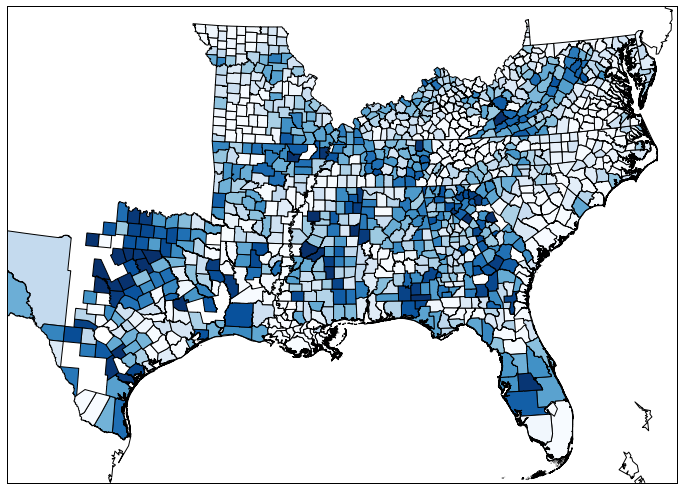

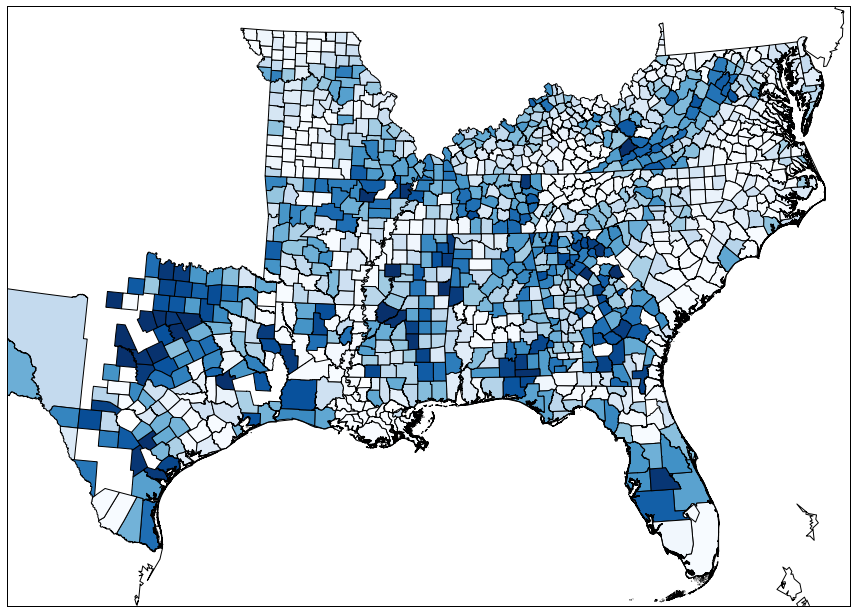

In [13]:
## (2) Graph for election of 1876
## (1) Graph for election of 1860
water = 'lightskyblue'
earth = 'cornsilk'
 
fig, ax1 = plt.subplots(figsize=(12, 10))
mm = Basemap(
    width=2600000, height=1850000,
    resolution='l',
    projection='aea',
    ellps='WGS84',
    lat_0=33., lon_0=-89)
coast = mm.drawcoastlines()
# continents = mm.fillcontinents(
#     color=earth,
#     lake_color=water)
# states = mm.drawstates(linewidth=1)
# bound = mm.drawmapboundary(fill_color=water)

## Add a linewidth call to the state shape file

mm.readshapefile(shape_files + '1870/intermediate/US_county_1870_reformatted', name='geometry', drawbounds=False)

## Heatmap based on democratic vote share
ax = plt.gca()
for geo_info, geo in zip(mm.geometry_info, mm.geometry):
    if (geo_info['STATENAM'].lower(), geo_info['NHGISNAM'].lower()) in vote_dict_1870:
        color = rgb2hex(vote_dict_1870[(geo_info['STATENAM'].lower(), geo_info['NHGISNAM'].lower())])
        poly=Polygon(geo, facecolor=color)
        ax.add_patch(poly)
    else:
        pass
        
## Also add state boundaries -- nice to use a thicker border relative to the county boundaries
## Maybe add a legend and mile marker
plt.tight_layout()
plt.savefig(figures + 'dem_share_1870.png')

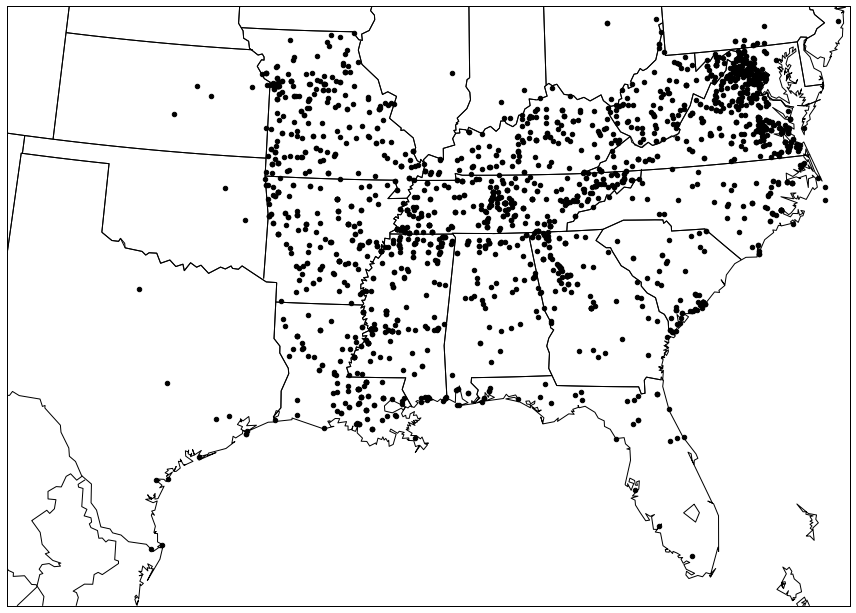

In [12]:
## (3) Graph for locations of casualty data and (hopefully) intensity
water = 'lightskyblue'
earth = 'cornsilk'
 
fig, ax1 = plt.subplots(figsize=(12, 10))
mm = Basemap(
    width=2600000, height=1850000,
    resolution='l',
    projection='aea',
    ellps='WGS84',
    lat_0=33., lon_0=-89.)
coast = mm.drawcoastlines()
# bound = mm.drawmapboundary(fill_color=water, zorder=0)
mm.drawstates(linewidth=1)
mm.drawcountries(linewidth=1)
# continents = mm.fillcontinents(
#     color=earth,
#     lake_color=water,
#     zorder=1)

## This should be state lines as opposed to county lines
# mm.readshapefile(shape_files + '1870/intermediate/US_county_1870_reformatted', name='geometry', drawbounds=True)

x, y = mm(casualties.longitude.values, casualties.latitude.values)
mm.scatter(x, y, color='black', zorder=2)

plt.tight_layout()
plt.savefig(figures + 'battles.png')

In [7]:
## (4) Graph of differences between 1872 and 1876 with casualty/intensity data
## Note: will probably only use (4) in the actual paper -- will blow it up